# 02 Feature Engineering (Volatility)

Goal:
Load volatility_base.csv and build a feature table X (predictors) aligned with target_vol. Save as data_processed/features.csv.

We’ll keep it simple but strong:

lagged volatility (persistence)

lagged returns (shock effects)

volatility-of-volatility (regime)

drawdown / trend features (risk state)

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf


In [34]:
base = pd.read_csv("../data_processed/volatility_base.csv", index_col=0, parse_dates=True)
base.head(), base.shape

(            realized_vol  target_vol
 Date                                
 2010-02-02      0.168565    0.203756
 2010-02-03      0.168364    0.202564
 2010-02-04      0.198115    0.204179
 2010-02-05      0.197179    0.203273
 2010-02-08      0.195957    0.211161,
 (3999, 2))

## Feature Engineering

### 1.1 Features based on the volatility difference
1. volatility is high on this week, it is often high on next week so we compute 3 different lags to compute this as a feature
2. the rv_change feature capture the rising or falling of volatility so the model can learn the dynamics of that

In [35]:
df = base.copy()

rv = df["realized_vol"]
# create lagged features
df["rv_lag1"] = rv.shift(1)
df["rv_lag5"] = rv.shift(5)
df["rv_lag20"] = rv.shift(20)

# Changes in volatility (vol trending up/down)
df["rv_change1"] = rv.diff(1)
df["rv_change5"] = rv.diff(5)

In [36]:
# new features to add due to benchmarking results
df["rv_mean5"] = rv.rolling(5).mean()
df["rv_mean20"] = rv.rolling(20).mean()
df["rv_mean60"] = rv.rolling(60).mean()

In [37]:
# download price again for easy processing
ticker = "SPY"
start_date = "2010-01-01"
end_date = "2026-01-01"

raw = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)
price_col = "Adj Close" if "Adj Close" in raw.columns else "Close"
prices = raw[price_col].squeeze().dropna().sort_index()

rets = np.log(prices).diff().dropna()
rets = rets.reindex(df.index)


### 1.2 Features based on the returns 
1. The return measure how the shock(return level) and the volatility relates, large absolute return tends to increase realized volatility.
2. rolling average of absolute return tell us the approximate recent dynamics
3. Why not raw returns? Raw returns oscillate around 0 and are noisy. Volatility responds more to magnitude than direction, so abs is usually more predictive.

In [38]:
# build the features with returns
df["ret_lag1"] = rets.shift(1)
df["ret_lag5"] = rets.shift(5)

# absolute returns proxy for daily shock size
df["abs_ret"] = rets.abs()
df["abs_ret_mean5"] = rets.abs().rolling(5).mean()
df["abs_ret_mean20"] = rets.abs().rolling(20).mean()


### 1.3 Measurement of the volatility of the volatility (rolling standard deviation)
1. They can help to find the regime stability / instability
2. Even if volatility is high, it matters if it is stable high or unstable high
3. This feature help the model to learn “high but stable” vs “high and chaotic” which often have different next-week behaviors.

In [39]:
df["vol_of_vol_20"] = rv.rolling(20).std()
df["vol_of_vol_60"] = rv.rolling(60).std()

### 1.4 Drawdown and trend features
1. What they capture: market risk state and leverage/deleveraging environments.

2. Drawdown is a compact way of encoding: “are we near recent highs or in a selloff?”

3. big drawdowns often coincide with higher vol and more persistence

4. MA ratio gives a simple “trend” proxy

5. trending down markets often have different vol dynamics than trending up markets

6. These help because volatility is not only a function of recent returns — it’s also linked to broader market stress.

In [40]:
rolling_max_60 = prices.rolling(60).max().reindex(df.index)
df["drawdown_60"] = (prices.reindex(df.index) / rolling_max_60 - 1.0)
# how many percent below the recent high

# Is the price in a short-term uptrend or downtrend compared to its medium-term level?
ma_20 = prices.rolling(20).mean().reindex(df.index)
ma_60 = prices.rolling(60).mean().reindex(df.index)
df["ma_ratio_20_60"] = (ma_20 / ma_60) - 1.0


### 1.5 Dataset cleaning, plotting and saving

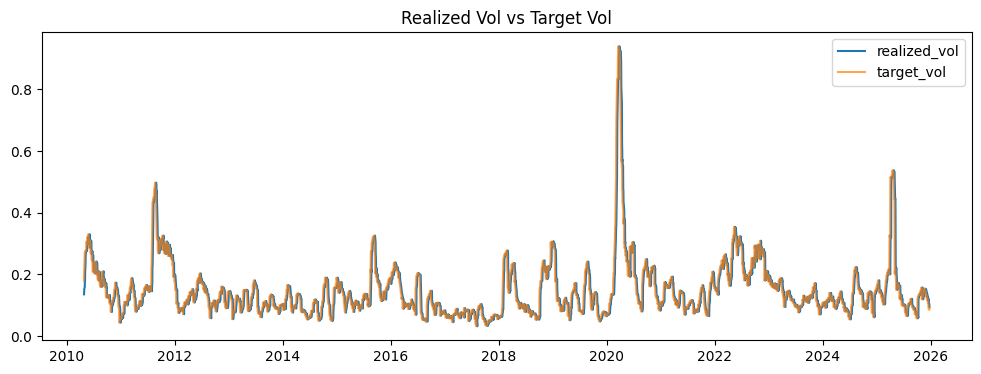

In [41]:
dataset = df.dropna()
dataset.head(), dataset.shape

# just check everything should be aligned
plt.figure(figsize=(12,4))
plt.plot(dataset.index, dataset["realized_vol"], label="realized_vol")
plt.plot(dataset.index, dataset["target_vol"], label="target_vol", alpha=0.7)
plt.title("Realized Vol vs Target Vol")
plt.legend()
plt.show()


In [42]:
dataset.to_csv("../data_processed/volatility_features.csv")
print("Saved: ../data_processed/volatility_features.csv")
print("Shape:", dataset.shape)

Saved: ../data_processed/volatility_features.csv
Shape: (3940, 19)
